In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.style
import matplotlib.pyplot as plt
year = 2020
#dati https://geodati.gov.it:443/geoportalRNDTPA/catalog/search/resource/details.page?uuid=PCM:COVID-19:05032020:093000
#aree https://geodati.gov.it/geoportalRNDTPA/catalog/search/resource/details.page?uuid=PCM:000086:20200306:110700
#dati nazionale https://github.com/pcm-dpc/COVID-19/tree/master/dati-andamento-nazionale
#dati regionale https://github.com/pcm-dpc/COVID-19/tree/master/dati-regioni
#dati province https://github.com/pcm-dpc/COVID-19/tree/master/dati-province
cvs_regionale_fileurl = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
months_days=(('02','24'),('02','25'),('02','26'),('02','27'),('02','28'),('02','29'),
             ('03','01'),('03','02'),('03','03'),('03','04'),('03','05'),('03','06'),
             ('03','07'),('03','08'),('03','09'),('03','10'),('03','11'),('03','12'),
             ('03','13'),('03','14'),('03','15'),('03','16'),('03','17'),('03','18'),
             ('03','19'),('03','20'),('03','21'))

from datetime import datetime
import pytz

local_tz = pytz.timezone('Europe/Rome')
rundate_iso = datetime.now(local_tz).isoformat().replace(':','-') # filename friendly
rundate_print = datetime.now(local_tz).strftime("%Y-%m-%d %H:%M %z CES")

#Population from Wikipedia, retrieved 18.03.2020 , [regional_code, region_name, region_population ]
regions_pd = pd.DataFrame([
    [1,'Piemonte', 4356406],
    [2,"Valle d'Aosta", 125666],
    [3,'Lombardia', 10060574],
    [4,'P.A. Bolzano', 533050],
    [104,'P.A. Trento', 541380],
    [5,'Veneto', 4905854],
    [6,'Friuli Venzia Giulia', 1215220],
    [7,'Liguria', 1550640],
    [8,'Emilia-Romagna', 4459477],
    [9,'Toscana', 3729641],
    [10,'Umbria', 882015],
    [11,'Marche', 1525271],
    [12,'Lazio', 5879082],
    [13,'Abruzzo', 1311580],
    [14,'Molise', 305617],
    [15,'Campania', 5801692],
    [16,'Puglia', 4029053],
    [17,'Basilicata', 562869],
    [18,'Calabria', 1947131],
    [19,'Sicilia', 4999891],
    [20,'Sardegna', 1639591]], columns=['code','region','P']) # P:population


In [2]:
pd.DataFrame([rundate_print]).to_clipboard(index=False,header=False)
print("Current run time: " + rundate_print)

Current run time: 2020-03-25 12:13 +0100 CES


In [3]:
# data,stato,codice_regione,denominazione_regione,lat,long,
# 1.ricoverati_con_sintomi,2.terapia_intensiva, 3. totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
# 2020-02-24 18:00:00,ITA,13,Abruzzo,42.35122196,13.39843823,0,0,0,0,0,0,0,0,0,5
# 2020-02-24 18:00:00,ITA,17,Basilicata,40.63947052,15.80514834,0,0,0,0,0,0,0,0,0,0
dtype_andamento_regionale="datetime64[s],S3,i8,S21,f8,f8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8"


<br>
<br>

## Retrieving and cleaning the dataset

<br>
<br>

In [4]:
#To avoid caching
from numpy.lib._datasource import DataSource
def openm(path, mode='r', destpath=None, encoding=None, newline=None):
    destpath=None
    ds = DataSource(destpath)
    return ds.open(path, mode, encoding=encoding, newline=newline)
np.lib._datasource.open=openm

rows_np = np.genfromtxt( 
        cvs_regionale_fileurl,
        dtype = dtype_andamento_regionale,
        delimiter=',', 
        names=True)

Exception ignored in: <function DataSource.__del__ at 0x000002416136DB88>
Traceback (most recent call last):
  File "c:\program files\python37\lib\site-packages\numpy\lib\_datasource.py", line 335, in __del__
    shutil.rmtree(self._destpath)
  File "c:\program files\python37\lib\shutil.py", line 516, in rmtree
    return _rmtree_unsafe(path, onerror)
  File "c:\program files\python37\lib\shutil.py", line 395, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onerror)
  File "c:\program files\python37\lib\shutil.py", line 395, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onerror)
  File "c:\program files\python37\lib\shutil.py", line 395, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onerror)
  [Previous line repeated 2 more times]
  File "c:\program files\python37\lib\shutil.py", line 400, in _rmtree_unsafe
    onerror(os.unlink, fullname, sys.exc_info())
  File "c:\program files\python37\lib\shutil.py", line 398, in _rmtree_unsafe
    os.unlink(fullname)
PermissionError: [WinError 32

In [5]:
rows_pd = pd.DataFrame(rows_np)

# Index(['data', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
#        'long', 'ricoverati_con_sintomi', 'terapia_intensiva',
#        'totale_ospedalizzati', 'isolamento_domiciliare',
#        'totale_attualmente_positivi', 'nuovi_attualmente_positivi',
#        'dimessi_guariti', 'deceduti', 'totale_casi', 'tamponi'],
#       dtype='object')

rows_pd.rename(columns={'data':'date',
                        'ricoverati_con_sintomi':'h', #hospitalized
                        'terapia_intensiva':'icu',
                        'totale_ospedalizzati':'h+icu', 
                        'isolamento_domiciliare':'q', #quarantine
                        'totale_attualmente_positivi': 'p', #positives
                        'nuovi_attualmente_positivi': 'np', #new positives
                        'dimessi_guariti':'d', #discharged 
                        'deceduti':'dc', #deceased 
                        'totale_casi':'T', 
                        'tamponi': 'S' #swabs
                       }, inplace=True)

rows_pd.index

RangeIndex(start=0, stop=630, step=1)

In [6]:
# b'P.A. Trento' and b'P.A. Bolzano' both share codice_regione==4 - setting P.A.Trento to 104
rows_pd.loc[rows_pd['denominazione_regione']==b'P.A. Trento','codice_regione']=104
#merge population from regions_pd
rows_pd=pd.merge(rows_pd, regions_pd, how='left', left_on='codice_regione', right_on='code',
         left_index=False, right_index=False, copy=True, 
         validate="m:1")

rows_pd.columns

Index(['date', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
       'long', 'h', 'icu', 'h+icu', 'q', 'p', 'np', 'd', 'dc', 'T', 'S',
       'code', 'region', 'P'],
      dtype='object')

In [82]:
# sets the last_day_of_data and data_date_iso/print for the filenames

last_day_of_data = rows_pd['date'].max()
data_date_iso = local_tz.localize(last_day_of_data).isoformat().replace(':','') # filename friendly
data_date_print = local_tz.localize(last_day_of_data).strftime("%Y-%m-%d %H:%M %z CES")
last_day_of_data=last_day_of_data.floor('d')
print(data_date_iso)
print(data_date_print)
print(last_day_of_data)

2020-03-24T170000+0100
2020-03-24 17:00 +0100 CES
2020-03-24 00:00:00


<br>
<br>
<br>

# Per 100k elaboration

<br>
<br>
<br>

In [121]:
def print_table(rows_pd, column, filename, timedelta = '7 days'):
    table_pd = rows_pd.loc[rows_pd['date']>last_day_of_data - pd.Timedelta('7 days')].pivot(index='date',columns='region')[column].T.iloc[:,[0,-1]].round(1)
    table_pd['Growth (linear)'] = table_pd.iloc[:,1].div(table_pd.iloc[:,0]).sub(1).mul(100).round(0).astype(str) + '%'
    table_pd = table_pd.sort_values(by=[table_pd.columns[1]], ascending=False)
    f = open("tables/" + filename,"w")
    f.write(table_pd.to_html())
    f.close()
    return table_pd

def print_plot(rows_pd, column, y_label, title, methodology, png_filename):
    plot = rows_pd.pivot(index='date',columns='region')[column].plot()
    plot.set_ylabel(y_label)
    plot.set_xlabel('Date')
    plot.set_title(title)
    plot_fig = plot.get_figure()
    plot_fig.set_size_inches(15, 10, forward=True)
    plot.text(0.1, 0.1, methodology, fontsize=14, transform=plt.gcf().transFigure)
    plt.savefig("plots/" + png_filename, format='png', dpi=80)

matplotlib.style.use('default')

<br>
<br>

## Number of tested positives per 100k inhabitants, by region

<br>
<br>

In [122]:
rows_pd.loc[:,'Tper100kP']=rows_pd['T'].div(rows_pd['P']).mul(100000)

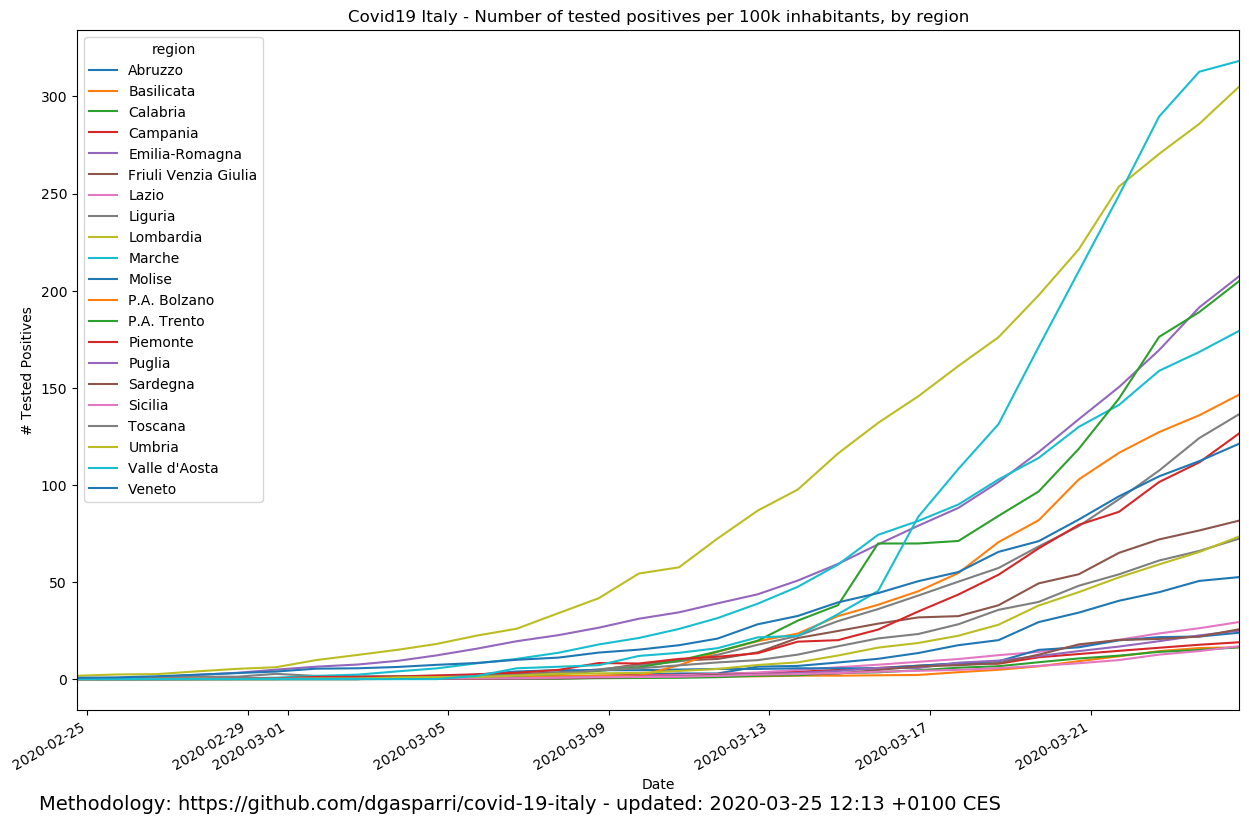

In [123]:
print_plot(rows_pd,  
           column = 'Tper100kP',
           y_label = '# Tested Positives',
           title = 'Covid19 Italy - Number of tested positives per 100k inhabitants, by region',
           methodology = "Methodology: https://github.com/dgasparri/covid-19-italy - updated: " + rundate_print,
           png_filename = "Tper100kP_"+ data_date_iso + ".png")

In [124]:
print_table(rows_pd, 
            column = 'Tper100kP', 
            filename = "Tper100kP_"+ data_date_iso + ".table", 
            timedelta = '7 days')

date,2020-03-17 17:00:00,2020-03-24 17:00:00,Growth (linear)
region,,,
Valle d'Aosta,108.2,318.3,194.0%
Lombardia,161.2,305.2,89.0%
Emilia-Romagna,88.1,207.5,136.0%
P.A. Trento,71.1,205.0,188.0%
Marche,89.9,179.4,100.0%
P.A. Bolzano,54.6,146.5,168.0%
Liguria,50.2,136.5,172.0%
Piemonte,43.5,126.6,191.0%
Veneto,55.1,121.2,120.0%


<br>
<br>
<br>

## Number of swabs performed per 100k inhabitants, by region

<br>
<br>
<br>

In [125]:
rows_pd.loc[:,'Sper100kP']=rows_pd['S'].div(rows_pd['P']).mul(100000)

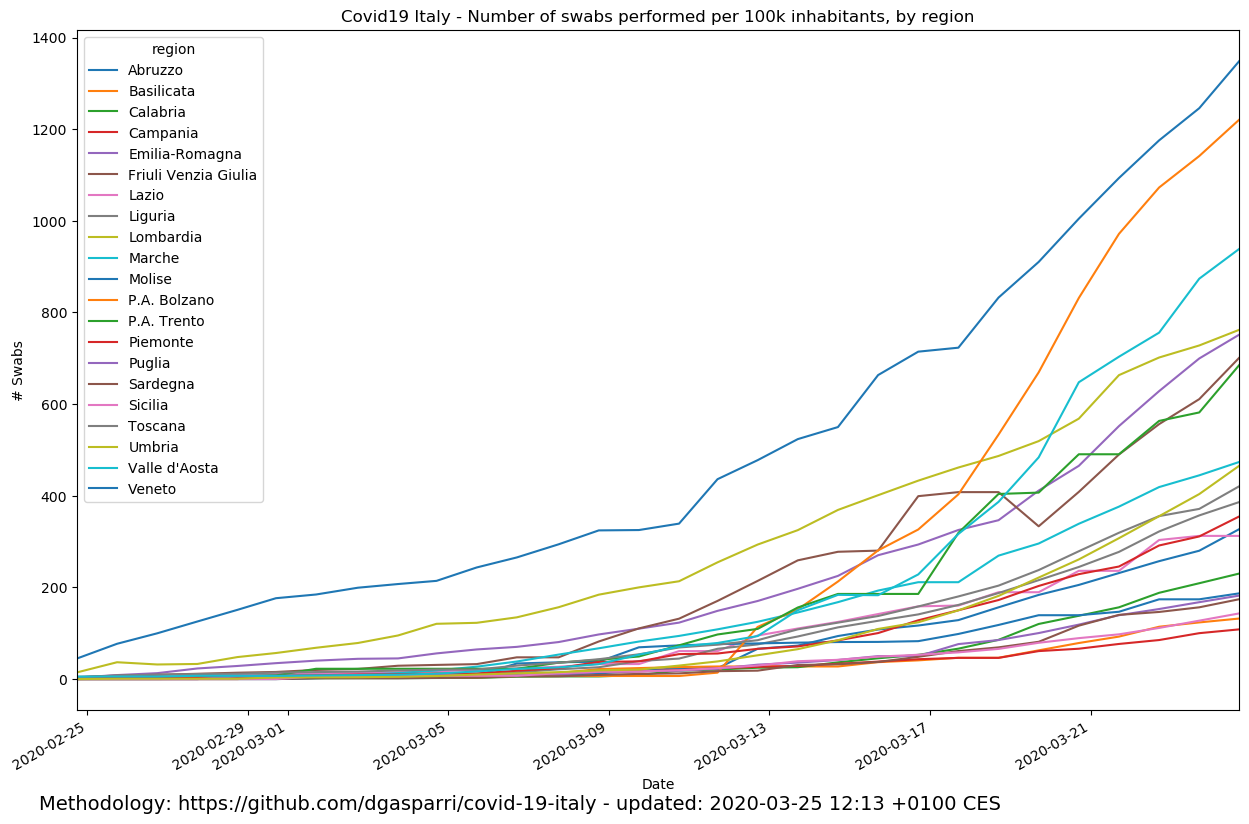

In [126]:
print_plot(rows_pd,  
           column = 'Sper100kP',
           y_label = '# Swabs',
           title = 'Covid19 Italy - Number of swabs performed per 100k inhabitants, by region',
           methodology = "Methodology: https://github.com/dgasparri/covid-19-italy - updated: " + rundate_print,
           png_filename = "Sper100kP_"+ data_date_iso + ".png")

In [127]:
print_table(rows_pd, 
            column = 'Sper100kP', 
            filename = "Sper100kP_"+ data_date_iso + ".table", 
            timedelta = '7 days')

date,2020-03-17 17:00:00,2020-03-24 17:00:00,Growth (linear)
region,,,
Veneto,723.2,1349.0,87.0%
P.A. Bolzano,403.2,1221.1,203.0%
Valle d'Aosta,316.7,939.0,196.0%
Lombardia,461.7,762.3,65.0%
Emilia-Romagna,325.4,751.8,131.0%
Friuli Venzia Giulia,408.0,701.6,72.0%
P.A. Trento,319.0,685.7,115.0%
Marche,211.4,473.9,124.0%
Umbria,150.0,465.8,211.0%


<br>
<br>
<br>

## Number of hospitalized (h+icu) per 100k inhabitants, by region

<br>
<br>
<br>

In [128]:
rows_pd.loc[:,'h+icuper100kP']=rows_pd['h+icu'].div(rows_pd['P']).mul(100000)

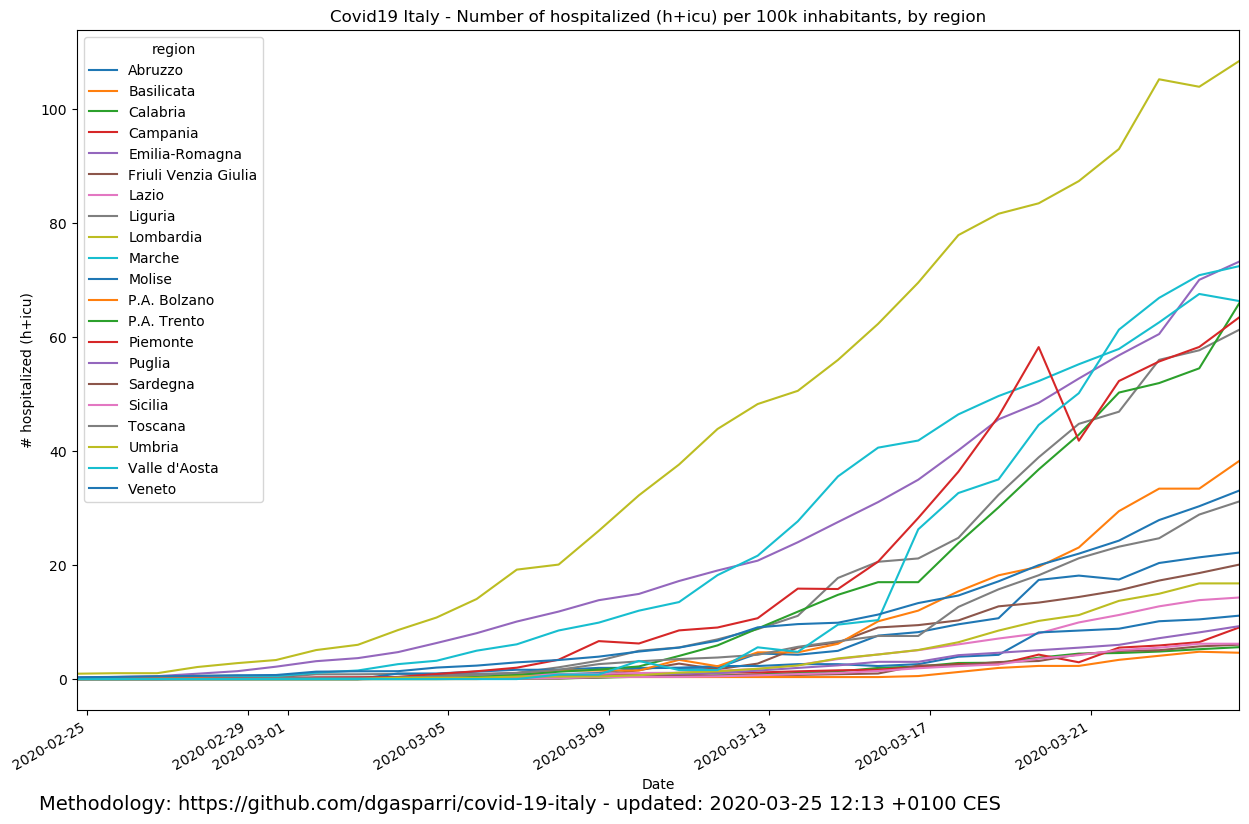

In [129]:
print_plot(rows_pd,  
           column = 'h+icuper100kP',
           y_label = '# hospitalized (h+icu)',
           title = 'Covid19 Italy - Number of hospitalized (h+icu) per 100k inhabitants, by region',
           methodology = "Methodology: https://github.com/dgasparri/covid-19-italy - updated: " + rundate_print,
           png_filename = "hicuper100kP_"+ data_date_iso + ".png")

In [130]:
print_table(rows_pd, 
            column = 'h+icuper100kP', 
            filename = "hicuper100kP_"+ data_date_iso + ".table", 
            timedelta = '7 days')

date,2020-03-17 17:00:00,2020-03-24 17:00:00,Growth (linear)
region,,,
Lombardia,77.8,108.4,39.0%
Emilia-Romagna,40.1,73.2,83.0%
Valle d'Aosta,32.6,72.4,122.0%
Marche,46.4,66.3,43.0%
P.A. Trento,23.8,65.9,177.0%
Piemonte,36.4,63.4,74.0%
Liguria,24.8,61.3,147.0%
P.A. Bolzano,15.4,38.3,149.0%
Veneto,14.7,33.1,125.0%


<br>
<br>
<br>

## Number of ICU patients per 100k inhabitants, by region

<br>
<br>
<br>

In [131]:
rows_pd.loc[:,'icuper100kP']=rows_pd['icu'].div(rows_pd['P']).mul(100000)

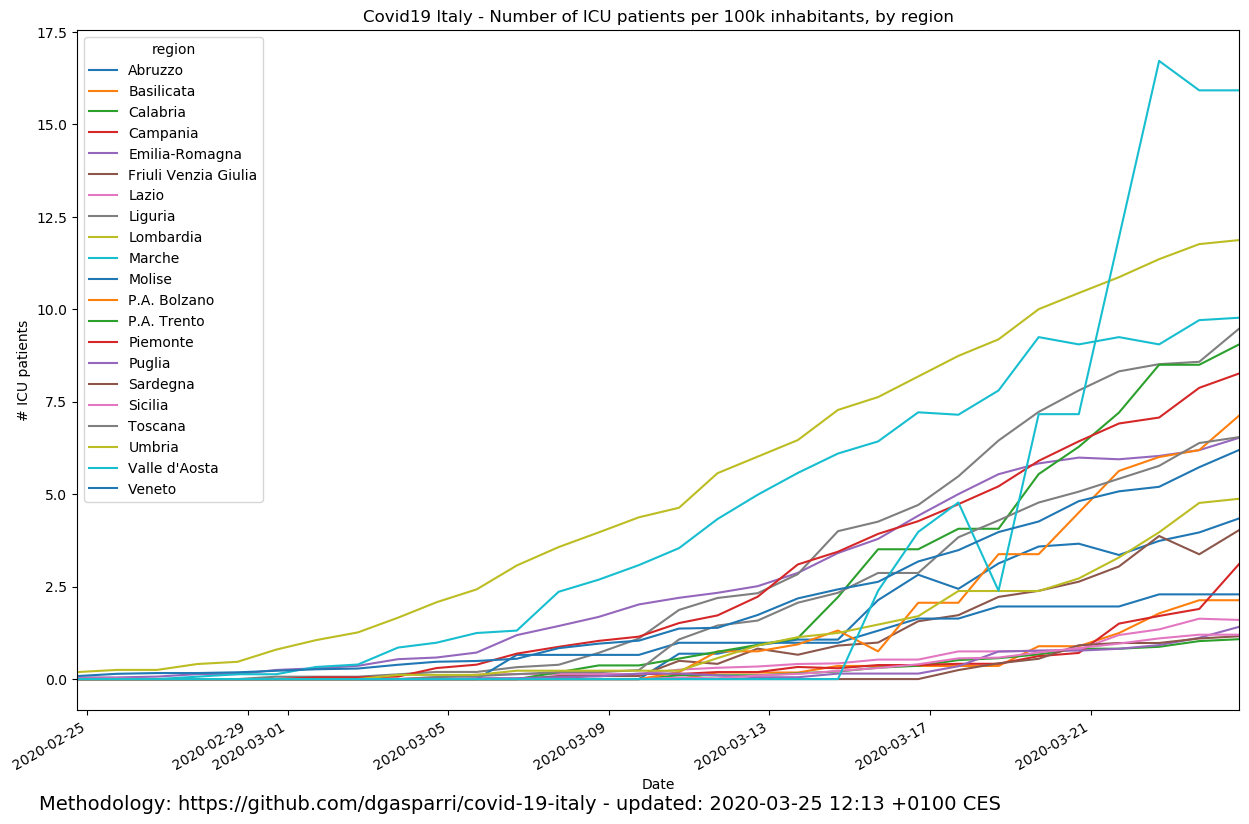

In [132]:
print_plot(rows_pd,  
           column = 'icuper100kP',
           y_label = '# ICU patients',
           title = 'Covid19 Italy - Number of ICU patients per 100k inhabitants, by region',
           methodology = "Methodology: https://github.com/dgasparri/covid-19-italy - updated: " + rundate_print,
           png_filename = "icuper100kP_"+ data_date_iso + ".png")

In [133]:
print_table(rows_pd, 
            column = 'icuper100kP', 
            filename = "icuper100kP_"+ data_date_iso + ".table", 
            timedelta = '7 days')

date,2020-03-17 17:00:00,2020-03-24 17:00:00,Growth (linear)
region,,,
Valle d'Aosta,4.8,15.9,231.0%
Lombardia,8.7,11.9,37.0%
Marche,7.1,9.8,38.0%
Liguria,5.5,9.5,73.0%
P.A. Trento,4.1,9.1,122.0%
Piemonte,4.7,8.3,77.0%
P.A. Bolzano,2.1,7.1,238.0%
Emilia-Romagna,5.0,6.5,30.0%
Toscana,3.8,6.5,71.0%


<br>
<br>
<br>

## Number of h patients per 100k inhabitants, by region

<br>
<br>
<br>

In [134]:
rows_pd.loc[:,'hper100kP']=rows_pd['h'].div(rows_pd['P']).mul(100000)

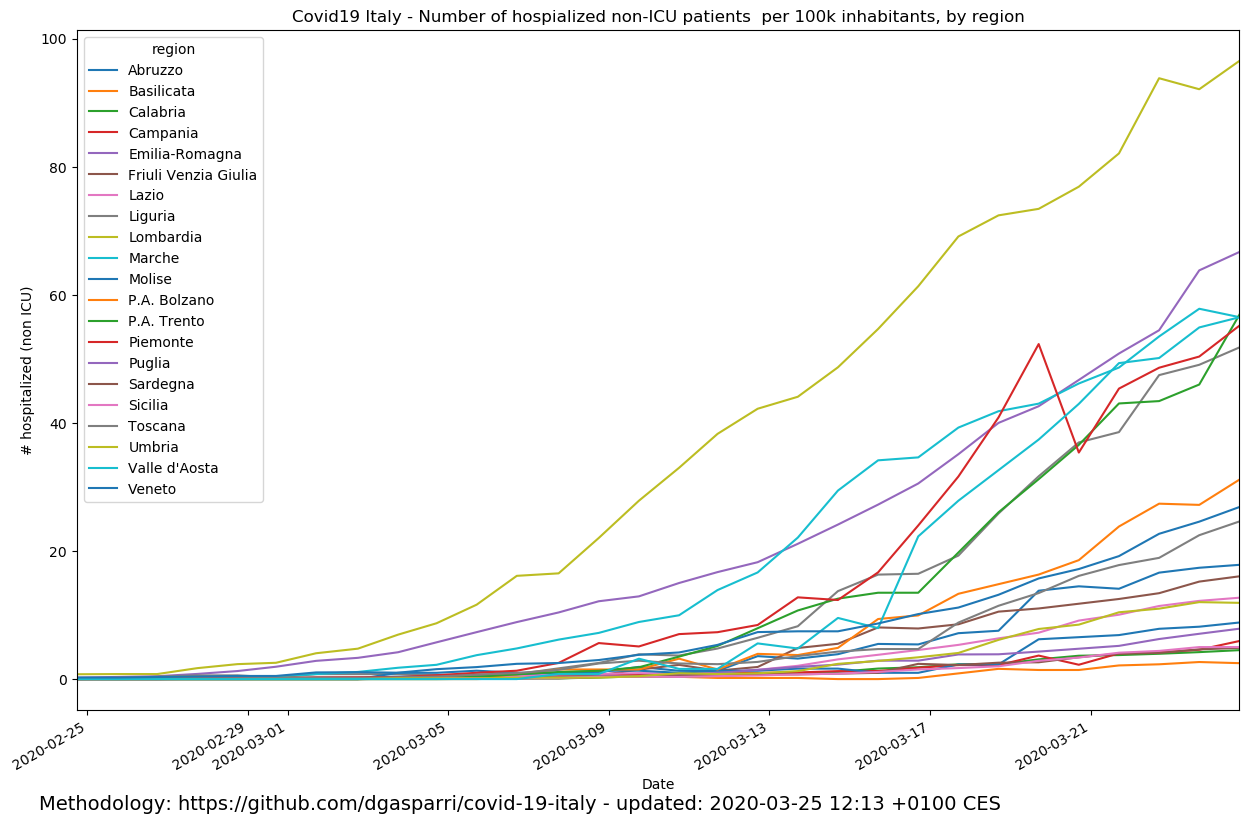

In [135]:
print_plot(rows_pd,  
           column = 'hper100kP',
           y_label = '# hospitalized (non ICU)',
           title = 'Covid19 Italy - Number of hospialized non-ICU patients  per 100k inhabitants, by region',
           methodology = "Methodology: https://github.com/dgasparri/covid-19-italy - updated: " + rundate_print,
           png_filename = "hper100kP_"+ data_date_iso + ".png")

In [136]:
print_table(rows_pd, 
            column = 'hper100kP', 
            filename = "hper100kP_"+ data_date_iso + ".table", 
            timedelta = '7 days')

date,2020-03-17 17:00:00,2020-03-24 17:00:00,Growth (linear)
region,,,
Lombardia,69.1,96.5,40.0%
Emilia-Romagna,35.1,66.7,90.0%
P.A. Trento,19.8,56.9,187.0%
Valle d'Aosta,27.9,56.5,103.0%
Marche,39.3,56.5,44.0%
Piemonte,31.6,55.2,75.0%
Liguria,19.3,51.8,168.0%
P.A. Bolzano,13.3,31.1,134.0%
Veneto,11.2,26.9,140.0%


<br>
<br>
<br>

## Number of deaths tested positive per 100k inhabitants, by region

<br>
<br>
<br>

In [137]:
rows_pd.loc[:,'dcper100kP']=rows_pd['dc'].div(rows_pd['P']).mul(100000)

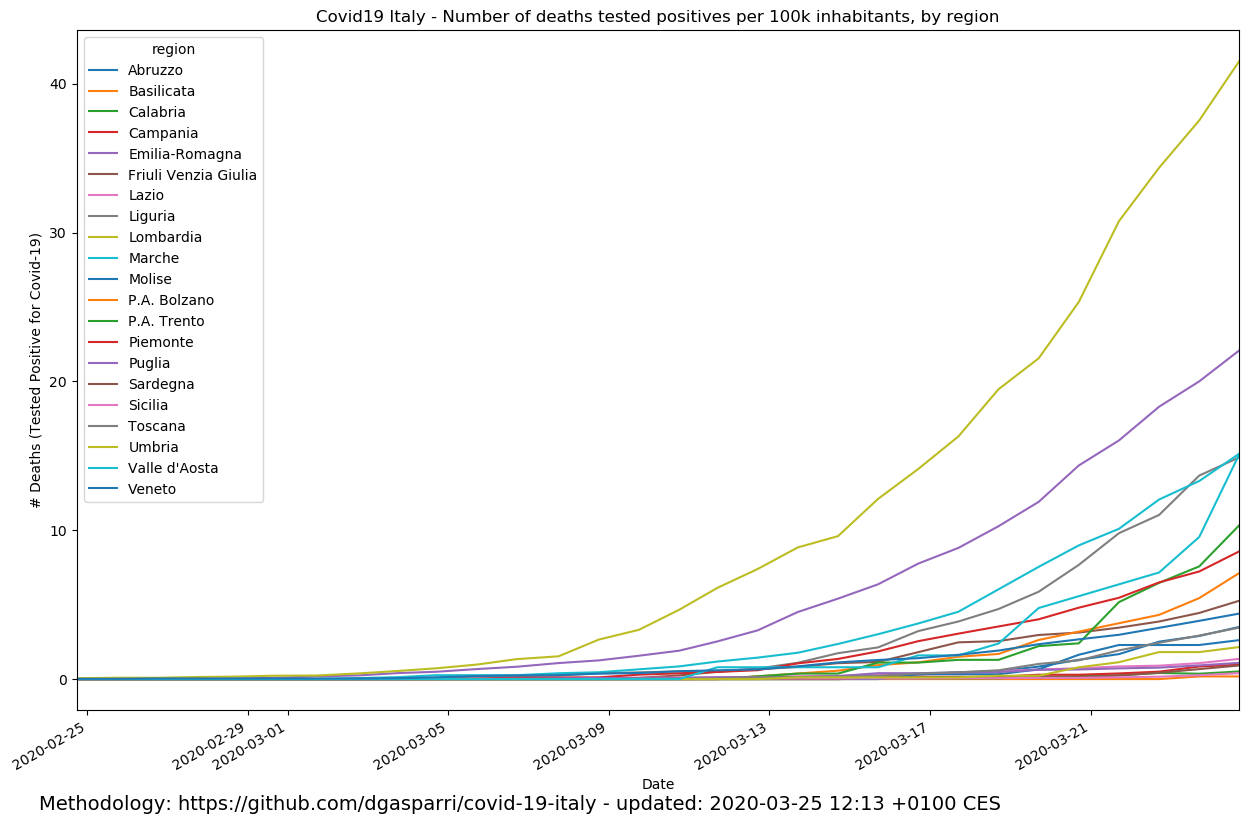

In [138]:
print_plot(rows_pd,  
           column = 'dcper100kP',
           y_label = '# Deaths (Tested Positive for Covid-19)',
           title = 'Covid19 Italy - Number of deaths tested positives per 100k inhabitants, by region',
           methodology = "Methodology: https://github.com/dgasparri/covid-19-italy - updated: " + rundate_print,
           png_filename = "dcper100kP_"+ data_date_iso + ".png")

In [139]:
print_table(rows_pd, 
            column = 'dcper100kP', 
            filename = "dcper100kP_"+ data_date_iso + ".table", 
            timedelta = '7 days')

date,2020-03-17 17:00:00,2020-03-24 17:00:00,Growth (linear)
region,,,
Lombardia,16.3,41.5,155.0%
Emilia-Romagna,8.8,22.1,151.0%
Valle d'Aosta,1.6,15.1,844.0%
Marche,4.5,15.1,236.0%
Liguria,3.9,14.9,282.0%
P.A. Trento,1.3,10.3,692.0%
Piemonte,3.1,8.6,177.0%
P.A. Bolzano,1.5,7.1,373.0%
Friuli Venzia Giulia,2.5,5.3,112.0%


In [141]:
rows_pd.to_csv('data/dpc-covid19-ita-regioni-per100k_'+ data_date_iso +'.csv', header = True, index = False)

<br>
<br>
<br>

# Analysis

<br>
<br>
<br>

In [28]:
rows_pd.columns

Index(['date', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
       'long', 'h', 'icu', 'h+icu', 'q', 'p', 'np', 'd', 'dc', 'T', 'S',
       'code', 'region', 'P', 'Tper100kP', 'Sper100kP', 'h+icuper100kP',
       'icuper100kP', 'hper100kP'],
      dtype='object')

In [54]:
per100k_pd = rows_pd.drop(axis=1,labels=['stato','codice_regione','denominazione_regione','lat','long','h','icu','h+icu','q','p','np','d','dc','T','S','P'])

#baseline

baseline_pd = pd.DataFrame([['Italia (cumul.)',
                        per100k_pd.loc[:,'Tper100kP'].mean(),
                        per100k_pd.loc[:,'Sper100kP'].mean(),
                        per100k_pd.loc[:,'h+icuper100kP'].mean(),
                        per100k_pd.loc[:,'icuper100kP'].mean(),
                        per100k_pd.loc[:,'hper100kP'].mean(),
                        last_day_of_data + pd.Timedelta(1,unit='s')
                       ]], columns=['region', 
                                    'Tper100kP', 
                                    'Sper100kP', 
                                    'h+icuper100kP',
                                    'icuper100kP',
                                    'hper100kP',
                                   'date']).round(0)
per100k_pd = per100k_pd.append(baseline_pd, sort=True)

per100k_pd.loc[:,'Swabs for each Tested Pos.']=per100k_pd['Sper100kP'].div(per100k_pd['Tper100kP']).round(0)
per100k_pd.loc[:,'Hosp.(all) over Swabs']=per100k_pd['h+icuper100kP'].div(per100k_pd['Sper100kP']).mul(100).round(0)
per100k_pd.loc[:,'Hosp.(all) over Tested Pos.']=per100k_pd['h+icuper100kP'].div(per100k_pd['Tper100kP']).mul(100).round(0)
per100k_pd.loc[:,'ICU over Swabs']=per100k_pd['icuper100kP'].div(per100k_pd['Sper100kP']).mul(100).round(0)
per100k_pd.loc[:,'ICU over Tested Pos.']=per100k_pd['icuper100kP'].div(per100k_pd['Tper100kP']).mul(100).round(0)
per100k_pd.loc[:,'ICU over Hosp. (all)']=per100k_pd['icuper100kP'].div(per100k_pd['h+icuper100kP']).mul(100).round(0)




per100k_pd.rename(columns={'Tper100kP':'Tested Positive',
                        'Sper100kP':'Covid-19 Swabs', #hospitalized
                        'icuper100kP':'Hospitalized (ICU)',
                        'h+icuper100kP':'Hospitalized (all)', 
                        'hper100kP':'Hospitalized (non-ICU)', #quarantine
                       }, inplace=True)


In [60]:
last_per100k_pd=pd.DataFrame(per100k_pd.loc[per100k_pd['date']>last_day_of_data].round(1).drop(axis=1,labels=['date','code']))
last_per100k_pd

,Covid-19 Swabs,Tested Positive,Hospitalized (all),Hospitalized (non-ICU),Hospitalized (ICU),region,Swabs for each Tested Pos.,Hosp.(all) over Swabs,Hosp.(all) over Tested Pos.,ICU over Swabs,ICU over Tested Pos.,ICU over Hosp. (all)
609,327.4,52.5,22.2,17.8,4.3,Abruzzo,6.0,7.0,42.0,1.0,8.0,20.0
610,132.2,16.3,4.6,2.5,2.1,Basilicata,8.0,3.0,28.0,2.0,13.0,46.0
611,1221.1,146.5,38.3,31.1,7.1,P.A. Bolzano,8.0,3.0,26.0,1.0,5.0,19.0
612,230.4,16.4,5.6,4.5,1.1,Calabria,14.0,2.0,34.0,0.0,7.0,19.0
613,108.5,19.0,9.1,5.9,3.1,Campania,6.0,8.0,48.0,3.0,16.0,34.0
614,751.8,207.5,73.2,66.7,6.5,Emilia-Romagna,4.0,10.0,35.0,1.0,3.0,9.0
615,701.6,81.6,20.1,16.0,4.0,Friuli Venzia Giulia,9.0,3.0,25.0,1.0,5.0,20.0
616,312.5,29.4,14.3,12.7,1.6,Lazio,11.0,5.0,49.0,1.0,5.0,11.0
617,386.4,136.5,61.3,51.8,9.5,Liguria,3.0,16.0,45.0,2.0,7.0,15.0
618,762.3,305.2,108.4,96.5,11.9,Lombardia,2.0,14.0,36.0,2.0,4.0,11.0


In [61]:
## Print HTML
pd.DataFrame([last_per100k_pd.to_html()]).to_clipboard(index=False,header=False)
#print(hover100kP_table.to_html())

In [62]:
last_per100k_extract_pd= last_per100k_pd.loc[last_per100k_pd['region'].isin(['Valle d\'Aosta','Lombardia','P.A. Trento','Marche','Emilia-Romagna'])]
last_per100k_extract_pd

,Covid-19 Swabs,Tested Positive,Hospitalized (all),Hospitalized (non-ICU),Hospitalized (ICU),region,Swabs for each Tested Pos.,Hosp.(all) over Swabs,Hosp.(all) over Tested Pos.,ICU over Swabs,ICU over Tested Pos.,ICU over Hosp. (all)
614,751.8,207.5,73.2,66.7,6.5,Emilia-Romagna,4.0,10.0,35.0,1.0,3.0,9.0
618,762.3,305.2,108.4,96.5,11.9,Lombardia,2.0,14.0,36.0,2.0,4.0,11.0
619,473.9,179.4,66.3,56.5,9.8,Marche,3.0,14.0,37.0,2.0,5.0,15.0
626,685.7,205.0,65.9,56.9,9.1,P.A. Trento,3.0,10.0,32.0,1.0,4.0,14.0
628,939.0,318.3,72.4,56.5,15.9,Valle d'Aosta,3.0,8.0,23.0,2.0,5.0,22.0
